In [2]:
%load_ext autoreload
%autoreload 2

import glob,time
import pylab as pl
import numpy as np
import matplotlib
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   astropy.table import Table, vstack, join, unique, hstack
from   desimodel.focalplane.geometry import xy2radec 
from   desimodel.io import load_fiberpos 
from   desitarget.geomask import circles 
from   desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask 

import healpy as hp
import pandas as pd
import matplotlib.gridspec as gridspec
from astropy.io import fits as fits
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable
from astropy.table import unique 

import math

import sys

'''
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools
'''
from desitarget.geomask import get_imaging_maskbits 
from bgsfunc import tile2rosette, get_tiles

nside = 32
orig_density_per_deg = 2500 #random

#files
sv3_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
main_survey_randoms = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits'

In [3]:
tiles = get_tiles()

In [4]:
#making full sv3 ledger 
ledger = vstack([Table.read(x) for x in glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')])

In [5]:
#update ledger so only have targets where initial priority is same as priority, i guess like first run 
ledger    = ledger[ledger['PRIORITY_INIT'] == ledger['PRIORITY']]

In [6]:
#list of tile ids for the rosette 15 - this is rosette we are working with for now 
tids      = tiles['TILEID'].data[tiles['ROSETTE'] == 15]
tids

array([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427])

In [7]:
#root for fibre assign files 
root      = '/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN/'

In [8]:
#list of all the sv3 nights so far i think
nights    = [x.split('/')[-1] for x in sorted(glob.glob(root + '/*'))]
nights.remove('SV3.ecsv')
nights

['20210405',
 '20210407',
 '20210408',
 '20210409',
 '20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417',
 '20210418',
 '20210419',
 '20210420',
 '20210422',
 '20210429',
 '20210430',
 '20210501',
 '20210502',
 '20210503',
 '20210504',
 '20210505',
 '20210506',
 '20210507',
 '20210508',
 '20210509',
 '20210510',
 '20210511',
 '20210512',
 '20210513',
 '20210514',
 '20210518',
 '20210521',
 '20210529']

In [9]:
datamodel = np.array([], dtype=[ 

    ('TILEID', '>i8'), ('LOCATION', '>i8'), ('TARGETID', '>i8'), 

    ('EXPID', '>f4') ]) 

 
t = Table(datamodel) 
# We'll use vstack of a list of interim tables.

f = fits.open('/global/cfs/cdirs/desi/spectro/redux/everest/exposures-everest.fits')
exposures_file = Table(f[1].data)

exposures = exposures_file['TILEID', 'EXPID']

#building full table based on individual tiles 
result = []


for night in nights:
    fbas      = sorted(glob.glob(root + '/' + night + '/fba-*.fits'))
    ts        = np.array([x.split('/')[-1].replace('.fits','').replace('fba-','') for x in fbas]).astype(np.int64)
    
    ts        = ts[np.isin(ts, tids)]
    
    print(night, ts)
    

    for i, tid in enumerate(ts):
        
        fpath = root + '/' + night + '/fba-{:06d}.fits'.format(tid)
        
        fba   = Table.read(fpath, hdu='FASSIGN')
        
        fba   = join(fba,  ledger, keys='TARGETID', join_type='left')
    
        # **  New  **: do the same for fba, this removes targets not in the (main survey, science) ledger.   
        fba   = fba[~fba['RA'].mask]

        # keep good fibres only for fba too 
        fba   = fba[fba['FIBERSTATUS'] == 0]
        
        # Keep only DESI targets
        fba   = fba[(fba['SV3_DESI_TARGET'].data & desi_mask['BGS_ANY']) != 0] 
        
        #we want table of targetid, location, fiber, tileid,expid
        #we set up subtable for first three
        subtable = fba['TARGETID', 'LOCATION', 'FIBER']
        
        #then add column which is the tileid repeated over the whole length of the table 
        subtable['TILEID'] = np.array([tid] * len(subtable))

        #we then find exposures for a given tile using the tielid file 
        tile_exps = exposures[np.isin(exposures['TILEID'], [tid])]
        
        all_exps = []
        
        subtable_orig = subtable
        
        #then we go through and copy the table so it is done for each exposure 
        for i in range(len(tile_exps['EXPID'].data)):
            
            exps = np.array([tile_exps['EXPID'].data[i]]* len(subtable_orig))
            all_exps.append(exps)
            
        subtable = [subtable]*len(tile_exps['EXPID'].data)
        subtable = vstack(subtable)
        
        subtable['EXPID'] = np.concatenate(all_exps)
        
            
        #and then we add this to total table as this was just for one tile 
        result.append(subtable)
            
        
        
assignment_database = vstack(result)

        
assignment_database.rename_column('TARGETID', 'REALASSIGNED_TARGETID')    

20210405 [417]


20210407 []
20210408 []
20210409 []
20210410 [418]
20210411 [419]
20210412 []
20210413 []
20210414 []
20210415 [420]
20210416 []
20210417 [421]
20210418 []
20210419 []
20210420 [422]
20210422 [423]
20210429 [424]
20210430 []
20210501 [425]
20210502 []
20210503 []
20210504 []
20210505 []
20210506 []
20210507 []
20210508 [426]
20210509 []
20210510 []
20210511 []
20210512 []
20210513 []
20210514 []
20210518 []
20210521 []
20210529 [427]


In [10]:
unique(assignment_database['TILEID','EXPID'])

TILEID,EXPID
int64,int32
417,84123
418,84245
419,84827
419,84828
420,85106
421,85518
422,85642
423,86513
424,86755


In [11]:
U = unique(assignment_database['TILEID', 'EXPID'])

#use '{:08d}'.format(123) when doing it generally
#and can use ! to use terminal 

tsnr_table = []

for i in range(len(U)):
    
    for p in range(0,10):
        tileid = U['TILEID'][i]
        expid = U['EXPID'][i]
        petal = p
        
        rules = [tileid == 425,expid == 87127,p == 5]

        
        if all(rules):
            continue 
        
        
        coadd_file = fits.open('/global/cfs/cdirs/desi/spectro/redux/everest/tiles/perexp/{}/{:08d}/coadd-{}-{}-exp{:08d}.fits'.format(U['TILEID'][i],U['EXPID'][i],p,U['TILEID'][i],U['EXPID'][i]))

        subtable = Table(coadd_file['FIBERMAP'].data)['LOCATION','TARGETID','COADD_FIBERSTATUS']

        subtable['TILEID'] = np.array([tileid]*len(coadd_file['FIBERMAP'].data))
        subtable['EXPID'] = np.array([expid]*len(coadd_file['FIBERMAP'].data))
        subtable['PETAL'] = np.array([p]*len(coadd_file['FIBERMAP'].data))

        subtsnr = Table(coadd_file['SCORES'].data)['TSNR2_BGS']

        assert  (len(subtsnr) == len(subtable))

        subtable['TSNR2_BGS'] = np.array(coadd_file['SCORES'].data['TSNR2_BGS'])
        
        
        #x = Table(coadd_file['SCORES'].data)['TSNR2_BGS', 'TARGETID']
        #x.rename_column('TARGETID', '_TID')

        #subtable['TSNR2_BGS'] = np.array(x['TSNR2_BGS'])
        # subtable['_TID'] = x['_TID']

        subtable.rename_column('TARGETID', 'TSNR_TARGETID')

        tsnr_table.append(subtable)

        
tsnr_table=vstack(tsnr_table)
        


In [12]:
tsnr_table

LOCATION,TSNR_TARGETID,COADD_FIBERSTATUS,TILEID,EXPID,PETAL,TSNR2_BGS
int64,int64,int32,int64,int32,int64,float32
311,39633441209188942,0,417,84123,0,1346.9923
272,39633443784491294,0,417,84123,0,1514.8828
252,39633443784493049,0,417,84123,0,1442.1736
156,39633446334629677,0,417,84123,0,1442.7393
198,39633443788686693,0,417,84123,0,1562.8406
204,616094196087915290,0,417,84123,0,1624.0398
233,39633443784494131,0,417,84123,0,1518.8994
172,39633443784494248,0,417,84123,0,1399.8635
310,616094193512612879,0,417,84123,0,1619.4718


In [13]:
S4MOCK_database = join(assignment_database, tsnr_table,keys=['TILEID', 'LOCATION', 'EXPID'], join_type='left') 

In [14]:
S4MOCK_database_targetid = S4MOCK_database.group_by('REALASSIGNED_TARGETID') 
S4MOCK_database_targetid
mask = S4MOCK_database_targetid.groups.keys['REALASSIGNED_TARGETID'] == 39633448876378013
S4MOCK_database_targetid.groups[mask]


REALASSIGNED_TARGETID,LOCATION,FIBER,TILEID,EXPID,TSNR_TARGETID,COADD_FIBERSTATUS,PETAL,TSNR2_BGS
int64,int64,int32,int64,int32,int64,int32,int64,float32
39633448876378013,8235,4422,424,86755,39633448876378013,512,8,551995.4
39633448876378013,8144,4303,425,86993,39633448876378013,0,8,1099.2766
39633448876378013,8144,4303,425,87127,39633448876378013,0,8,508.38992
39633448876378013,8144,4303,425,87261,39633448876378013,0,8,334.1482
39633448876378013,8144,4303,425,87262,39633448876378013,0,8,298.74142


In [15]:
tsnr_col = []
num_exp_col = []

for i in range(len(S4MOCK_database_targetid.groups)):
    tsnr = 0 
    num_exp = 0
    for j in range(len(S4MOCK_database_targetid.groups[i])):
        tsnr +=S4MOCK_database_targetid.groups[i][j]['TSNR2_BGS']
        num_exp +=1
    tsnr_col.append(tsnr)
    num_exp_col.append(num_exp)

tsnr_col = np.array(tsnr_col)
num_exp_col = np.array(num_exp_col)

<ipython-input-15-419ee54e4c9d>:13: UserWarning: Warning: converting a masked element to nan.
  tsnr_col = np.array(tsnr_col)


In [16]:
y = S4MOCK_database_targetid.groups.keys
y['TSNR']= tsnr_col
y['NUMEXP']=num_exp_col


y[y['REALASSIGNED_TARGETID'] == 39633448876378013]

REALASSIGNED_TARGETID,TSNR,NUMEXP
int64,float64,int64
39633448876378013,554235.9311523438,5


In [17]:
y.rename_column('REALASSIGNED_TARGETID','TARGETID')
x = join(y,  ledger, keys='TARGETID', join_type='left')
y.rename_column('TARGETID','REALASSIGNED_TARGETID')
y['RA']= x['RA']
y['DEC']= x['DEC']
x

TARGETID,TSNR,NUMEXP,RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
,,,deg,deg,yr,mas,mas / yr,mas / yr,,,,,,,,,,,,,,,s,,
int64,float64,int64,float64,float64,float32,float32,float32,float32,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,float64,int64,int32,str30,str19,str6,int64
39633435978895151,1573.8010864257812,2,268.4870725263746,64.3709066010911,0.0,0.0,0.0,0.0,1152921504606855433,514,0,0.3883512982091777,517,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100
39633435983089279,1711.381103515625,2,269.0515603499875,64.36258359539647,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0.5265788927844653,516,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100
39633435983089911,1793.1516723632812,2,269.13636504003824,64.36344716212128,0.0,0.0,0.0,0.0,1152921504606846976,265,0,0.01111439934281111,516,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100
39633435987280232,1755.947769165039,4,269.18007527287386,64.35990518582318,0.0,0.0,0.0,0.0,1152921504606847233,514,0,0.3261263894551598,517,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100
39633435987280309,2304.890625,1,269.18932381886276,64.34420369978993,0.0,0.0,0.0,0.0,1152921504606846976,514,0,0.6317522263090186,516,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100
39633435987281447,15229.498779296875,3,269.3539908646265,64.3556964072958,0.0,0.0,0.0,0.0,1152921504606846976,257,0,0.35252911446362245,516,102000,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102000
39633435987281579,1743.2022705078125,2,269.37198567728814,64.32694405470633,0.0,0.0,0.0,0.0,1152921504606846976,265,0,0.0013519000132932169,516,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100
39633435987282090,1775.424072265625,2,269.4429552240157,64.30720863896086,0.0,0.0,0.0,0.0,1152921504606846976,265,0,0.6690112486842467,516,102100,9,0,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:50,0.57.0,102100


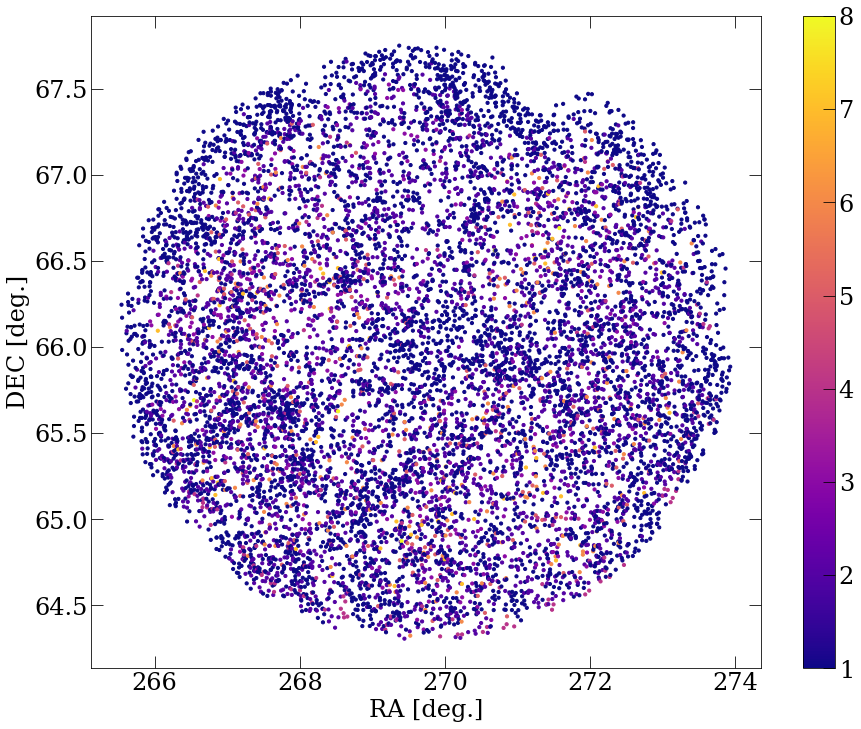

In [18]:
plt.rc('font', family='serif',size=24)
plt.rc('xtick',direction='in',labelsize=24,top=True)
plt.rc('ytick',direction='in',labelsize=24, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 24)

tsnr_mask = (y['TSNR']<7500)

plt.figure(figsize=(15,12))
x = plt.scatter(y['RA'][tsnr_mask],y['DEC'][tsnr_mask],c=y['NUMEXP'][tsnr_mask],cmap="plasma",s=10)
plt.xlabel('RA [deg.]')
plt.ylabel('DEC [deg.]')
plt.colorbar(x)
plt.savefig('tsnr_map2.png')

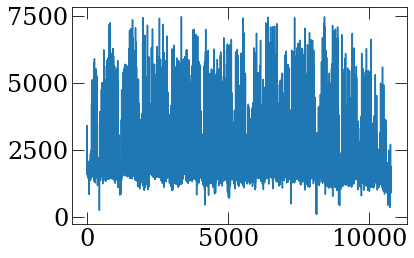

In [19]:
plt.plot(np.array(y['TSNR'][tsnr_mask]))

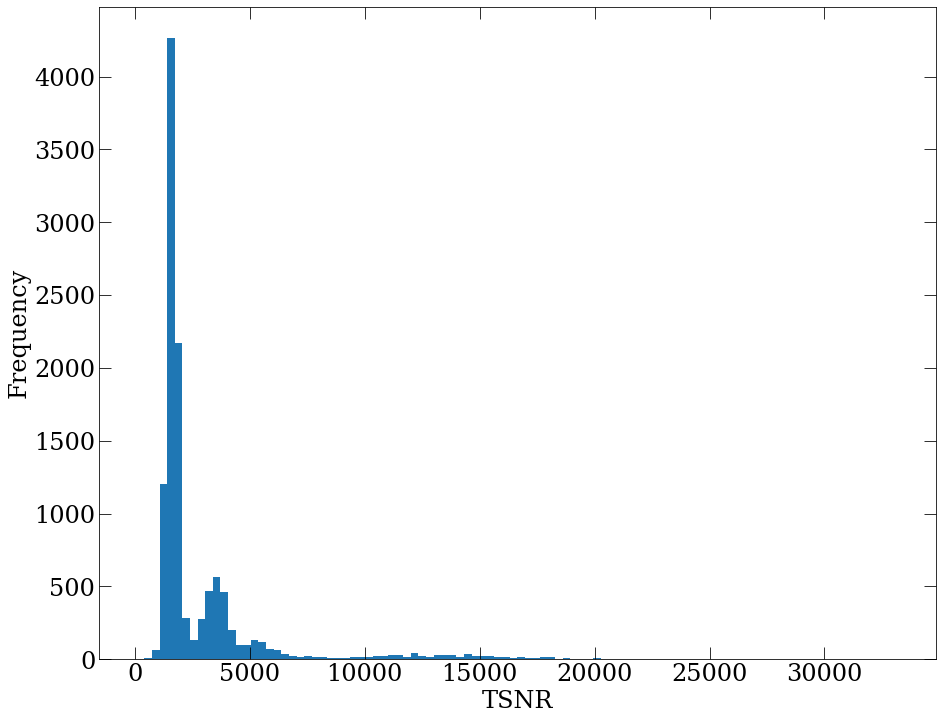

In [20]:
plt.rc('font', family='serif',size=24)
plt.rc('xtick',direction='in',labelsize=24,top=True)
plt.rc('ytick',direction='in',labelsize=24, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 24)

tsnr_mask = (y['TSNR']<100000)

plt.figure(figsize=(15,12))

plt.hist(np.array(y['TSNR'][tsnr_mask]),bins=100)
plt.xlabel('TSNR')
plt.ylabel('Frequency')
plt.savefig('tsnr_hist.png')

In [66]:
y.rename_column('REALASSIGNED_TARGETID','TARGETID')
x = join(y,  ledger, keys='TARGETID', join_type='left')
y.rename_column('TARGETID','REALASSIGNED_TARGETID')
y['RA']= x['RA']
y['DEC']= x['DEC']
x

nan

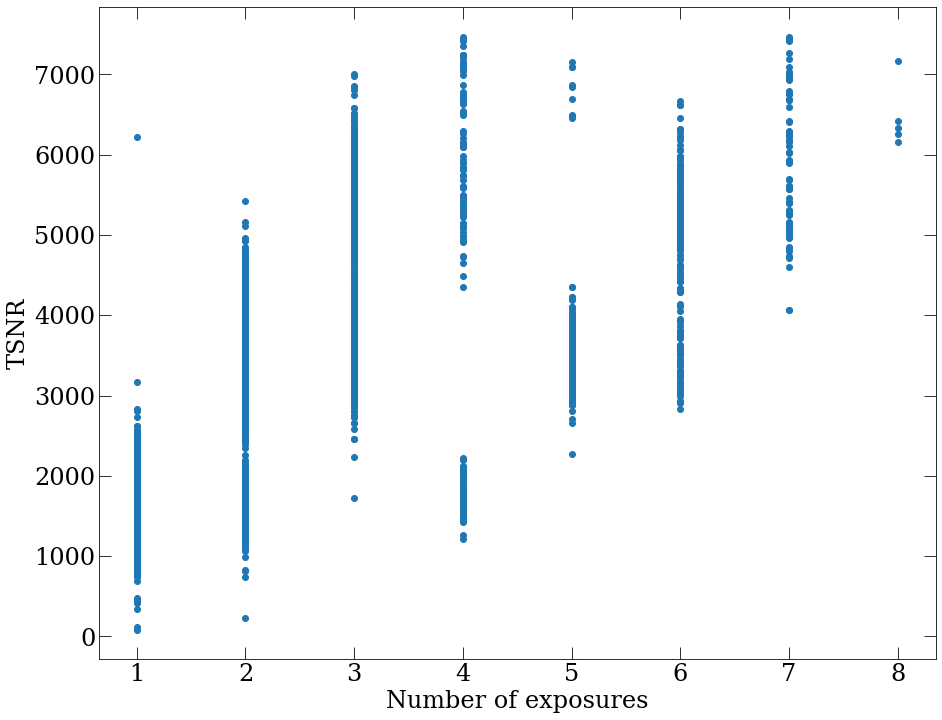

In [86]:
plt.rc('font', family='serif',size=24)
plt.rc('xtick',direction='in',labelsize=24,top=True)
plt.rc('ytick',direction='in',labelsize=24, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 24)



plt.figure(figsize=(15,12))

plt.scatter(y['NUMEXP'][(y['TSNR']<7500)],y['TSNR'][(y['TSNR']<7500)])
plt.ylabel('TSNR')
plt.xlabel('Number of exposures')
plt.savefig('TSNR_numexp3.png')